[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Random under-sampling:
1    4215
0    4215
Name: Label, dtype: int64


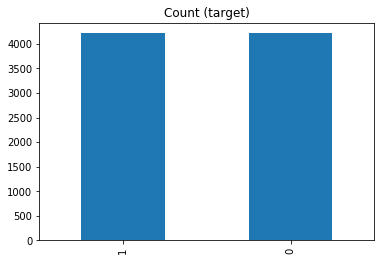

In [1]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# import classifiers
from sklearn import model_selection, naive_bayes, svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#Set Random seed
np.random.seed(500)

# Add the Data using pandas
Corpus = pd.read_csv("annotation_causal.csv") 

# Step - 1: Data Pre-processing

# Step - 1a : Remove blank rows if any.
Corpus['Sentence'].dropna(inplace=True)

# Step - 1b : Change all the text to lower case.
Corpus['Sentence'] = [entry.lower() for entry in Corpus['Sentence']]

# Step - 1c : Tokenization : In this each entry in the corpus will be broken into set of words
Corpus['Sentence'] = [word_tokenize(entry) for entry in Corpus['Sentence']]

# Step - 1d : Remove Non-Numeric words

# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index,entry in enumerate(Corpus['Sentence']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    for word, tag in pos_tag(entry):
        # Below condition is to  consider only alphabets
        if word.isalpha():
            Final_words.append(word)
    # The final processed set of words for each iteration will be stored in 'text_final'
    Corpus.loc[index,'text_final'] = str(Final_words)

Corpus['Label'] = Corpus[Corpus.columns[1:7]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)

for index, row in Corpus.iterrows():
    Corpus.at[index,'Label'] = int(float(row['Label'][0:3]))

Corpus.drop(Corpus.columns[[0,1,2,3,4,5,6,]], axis=1, inplace=True)

# Apply Random Under Sampling
# Class count
count_class_non_causal, count_class_causal = Corpus.Label.value_counts()

# Divide by class
df_class_non_causal = Corpus[Corpus['Label'] == 0]
df_class_causal = Corpus[Corpus['Label'] == 1]

# undersample "non causal" class
df_class_non_causal_under = df_class_non_causal.sample(count_class_causal)
df_undersampled = pd.concat([df_class_non_causal_under, df_class_causal], axis=0)

print('Random under-sampling:')
print(df_undersampled.Label.value_counts())

df_undersampled.Label.value_counts().plot(kind='bar', title='Count (target)');

Corpus = df_undersampled

In [2]:
# Step - 2: Split the model into Train and Test Data set
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus['text_final'],Corpus['Label'],test_size=0.1)

# Step - 3: Label encode the target variable - This is done to transform Categorical data of string type in the data set into numerical values
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

# Step - 4: Vectorize the words by using TF-IDF Vectorizer - This is done to find how important a word in document is in comaprison to the corpus
Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(Corpus['text_final'])

# Try Count Vectorizer for word embedding
Count_vect = CountVectorizer()
Count_vect.fit(Corpus['text_final'])

# decide which word embedding you want to use
embedding = ['TFIDF', 'Count_Vector']

# names of our two classes which we want to predict
target_names = ['not causal', 'causal']

# result data frame
results_df = pd.DataFrame(columns=['Method', 'Best_Params', 'Embedding', 'F1_Causal', 'F1_NonCausal', 'Recall_Causal', 'Recall_NonCausal', 'Precision_Causal', 'Precision_NonCausal', 'Accuracy', 'AUC'])

# Step - 5: Now we can run different algorithms to classify out data check for accuracy
for i in range(0,2):   
        if i == 0:
            Train_X_Tfidf = Tfidf_vect.transform(Train_X)
            Test_X_Tfidf = Tfidf_vect.transform(Test_X)
        elif i == 1:
            Train_X_Tfidf = Count_vect.transform(Train_X)
            Test_X_Tfidf = Count_vect.transform(Test_X) 

        # Classifier - Algorithm - Naive Bayes
        # fit the training dataset on the classifier
        Naive = naive_bayes.MultinomialNB()
                   
        # define parameters we want to "tune"    
        parameters_Naive = {'fit_prior':[True, False], 'alpha': [1, 1e-1, 1e-2]}
        
        print('-- Start GridSearch for Naive Bayes --')
        grid_Naive = GridSearchCV(Naive, parameters_Naive, cv=10, scoring='accuracy', n_jobs=-1)
        
        grid_Naive.fit(Train_X_Tfidf,Train_Y)
        
        # predict the labels on validation dataset with best model
        predictions_NB = grid_Naive.predict(Test_X_Tfidf)

        # Add Naive Bayes results to our dataframe
        report = classification_report(Test_Y, predictions_NB, target_names=target_names, output_dict=True)

        new_row = {'Method': 'Naive Bayes', 'Best_Params': grid_Naive.best_params_, 'Embedding': embedding[i] , 'F1_Causal': report['causal']['f1-score'], 'F1_NonCausal': report['not causal']['f1-score'], 'Recall_Causal': report['causal']['recall'], 'Recall_NonCausal': report['not causal']['recall'], 'Precision_Causal': report['causal']['precision'], 'Precision_NonCausal': report['not causal']['precision'], 'Accuracy': report['accuracy'], 'AUC': roc_auc_score(Test_Y, predictions_NB) }

        results_df = results_df.append(new_row, ignore_index=True)

        # Classifier - Algorithm - SVM
        # fit the training dataset on the classifier
        SVM = svm.SVC()
        
        parameters_SVM = {'gamma': [1e-3, 1e-4, 1e-5, 'auto'], 'C': [1, 50, 100], 'kernel': ['rbf', 'linear']}
        
        print('-- Start GridSearch for SVM --')
        grid_SVM = GridSearchCV(SVM, parameters_SVM, cv=10, scoring='accuracy', n_jobs=-1)
        
        grid_SVM.fit(Train_X_Tfidf,Train_Y)
        
         # predict the labels on validation dataset 
        predictions_SVM = grid_SVM.predict(Test_X_Tfidf)

        # Add Support Vector Machine results to our dataframe
        report = classification_report(Test_Y, predictions_SVM, target_names=target_names, output_dict=True)

        new_row = {'Method': 'SVM', 'Best_Params': grid_SVM.best_params_, 'Embedding': embedding[i] , 'F1_Causal': report['causal']['f1-score'], 'F1_NonCausal': report['not causal']['f1-score'], 'Recall_Causal': report['causal']['recall'], 'Recall_NonCausal': report['not causal']['recall'], 'Precision_Causal': report['causal']['precision'], 'Precision_NonCausal': report['not causal']['precision'], 'Accuracy': report['accuracy'], 'AUC': roc_auc_score(Test_Y, predictions_SVM) }

        results_df = results_df.append(new_row, ignore_index=True)

        # Classifier - Algorithm - Random Forest
        # fit the training dataset on the classifier
        clf = RandomForestClassifier(random_state=0)
       
        parameters_clf = {'n_estimators': [100, 200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'criterion' :['gini', 'entropy']}
        
        print('-- Start GridSearch for Random Forest --')
        grid_clf = GridSearchCV(clf, parameters_clf, cv=10, scoring='accuracy', n_jobs=-1)
        
        grid_clf.fit(Train_X_Tfidf,Train_Y)    

        # predict the labels on validation dataset
        predictions_clf = grid_clf.predict(Test_X_Tfidf)

        # Add Random Forest results to our dataframe
        report = classification_report(Test_Y, predictions_clf, target_names=target_names, output_dict=True)

        new_row = {'Method': 'Random Forest', 'Best_Params': grid_clf.best_params_, 'Embedding': embedding[i] , 'F1_Causal': report['causal']['f1-score'], 'F1_NonCausal': report['not causal']['f1-score'], 'Recall_Causal': report['causal']['recall'], 'Recall_NonCausal': report['not causal']['recall'], 'Precision_Causal': report['causal']['precision'], 'Precision_NonCausal': report['not causal']['precision'], 'Accuracy': report['accuracy'], 'AUC': roc_auc_score(Test_Y, predictions_clf) }

        results_df = results_df.append(new_row, ignore_index=True)

        # Classifier - Algorithm - Decision Tree
        # fit the training dataset on the classifier
        dt = DecisionTreeClassifier(random_state=0)
        
        parameters_dt = {'splitter': ['best', 'random'], 'max_features': ['auto', 'sqrt', 'log2'], 'criterion' :['gini', 'entropy']}
        
        print('-- Start GridSearch for Decision Tree --')
        grid_dt = GridSearchCV(dt, parameters_dt, cv=10, scoring='accuracy', n_jobs=-1)
        
        grid_dt.fit(Train_X_Tfidf,Train_Y)   

        # predict the labels on validation dataset
        predictions_dt = grid_dt.predict(Test_X_Tfidf)

        # Add Decision Tree results to our dataframe
        report = classification_report(Test_Y, predictions_dt, target_names=target_names, output_dict=True)

        new_row = {'Method': 'Decision Tree', 'Best_Params': grid_dt.best_params_, 'Embedding': embedding[i] , 'F1_Causal': report['causal']['f1-score'], 'F1_NonCausal': report['not causal']['f1-score'], 'Recall_Causal': report['causal']['recall'], 'Recall_NonCausal': report['not causal']['recall'], 'Precision_Causal': report['causal']['precision'], 'Precision_NonCausal': report['not causal']['precision'], 'Accuracy': report['accuracy'], 'AUC': roc_auc_score(Test_Y, predictions_dt) }

        results_df = results_df.append(new_row, ignore_index=True)

        # Classifier - Algorithm - Logistic Regression
        # fit the training dataset on the classifier
        lr = LogisticRegression(random_state=0,max_iter = 4000)
        
        parameters_lr = {'C': [0.001, 0.01, 0.1, 1, 10], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
        
        print('-- Start GridSearch for Logistic Regression --')
        grid_lr = GridSearchCV(lr, parameters_lr, cv=10, scoring='accuracy', n_jobs=-1)
        
        grid_lr.fit(Train_X_Tfidf,Train_Y)   

        # predict the labels on validation dataset
        predictions_lr = grid_lr.predict(Test_X_Tfidf)

        # Add Logistic Regression results to our dataframe
        report = classification_report(Test_Y, predictions_lr, target_names=target_names, output_dict=True)

        new_row = {'Method': 'Logistic Regression', 'Best_Params': grid_lr.best_params_, 'Embedding': embedding[i] , 'F1_Causal': report['causal']['f1-score'], 'F1_NonCausal': report['not causal']['f1-score'], 'Recall_Causal': report['causal']['recall'], 'Recall_NonCausal': report['not causal']['recall'], 'Precision_Causal': report['causal']['precision'], 'Precision_NonCausal': report['not causal']['precision'], 'Accuracy': report['accuracy'], 'AUC': roc_auc_score(Test_Y, predictions_lr) }

        results_df = results_df.append(new_row, ignore_index=True)

        # Classifier - Algorithm - AdaBoost
        # fit the training dataset on the classifier
        adaBoost = AdaBoostClassifier(random_state=0)
        
        parameters_ada = {'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [50, 100, 200]}
        
        print('-- Start GridSearch for Ada Boost --')
        grid_ada = GridSearchCV(adaBoost, parameters_ada, cv=10, scoring='accuracy', n_jobs=-1)
        
        grid_ada.fit(Train_X_Tfidf,Train_Y)

        # predict the labels on validation dataset
        predictions_adaBoost = grid_ada.predict(Test_X_Tfidf)

        # Add AdaBoost results to our dataframe
        report = classification_report(Test_Y, predictions_adaBoost, target_names=target_names, output_dict=True)

        new_row = {'Method': 'AdaBoost', 'Best_Params': grid_ada.best_params_, 'Embedding': embedding[i] , 'F1_Causal': report['causal']['f1-score'], 'F1_NonCausal': report['not causal']['f1-score'], 'Recall_Causal': report['causal']['recall'], 'Recall_NonCausal': report['not causal']['recall'], 'Precision_Causal': report['causal']['precision'], 'Precision_NonCausal': report['not causal']['precision'], 'Accuracy': report['accuracy'], 'AUC': roc_auc_score(Test_Y, predictions_adaBoost) }

        results_df = results_df.append(new_row, ignore_index=True)

        # Classifier - Algorithm - K Nearest Neighbor
        # fit the training dataset on the classifier
        kNeighbor = KNeighborsClassifier()
        
        parameters_knei = {'weights': ['uniform', 'distance'], 'n_neighbors': list(range(1, 21)), 'algorithm': ['ball_tree', 'kd_tree']}
        
        print('-- Start GridSearch for K Neighbor --')
        grid_knei = GridSearchCV(kNeighbor, parameters_knei, cv=10, scoring='accuracy', n_jobs=-1)
        
        grid_knei.fit(Train_X_Tfidf,Train_Y)

        # predict the labels on validation dataset
        predictions_kNeighbor = grid_knei.predict(Test_X_Tfidf)

        # Add K Nearest Neighbor results to our dataframe
        report = classification_report(Test_Y, predictions_kNeighbor, target_names=target_names, output_dict=True)

        new_row = {'Method': 'K Nearest Neighbor', 'Best_Params': grid_knei.best_params_, 'Embedding': embedding[i] , 'F1_Causal': report['causal']['f1-score'], 'F1_NonCausal': report['not causal']['f1-score'], 'Recall_Causal': report['causal']['recall'], 'Recall_NonCausal': report['not causal']['recall'], 'Precision_Causal': report['causal']['precision'], 'Precision_NonCausal': report['not causal']['precision'], 'Accuracy': report['accuracy'], 'AUC': roc_auc_score(Test_Y, predictions_kNeighbor) }

        results_df = results_df.append(new_row, ignore_index=True)


-- Start GridSearch for Naive Bayes --
-- Start GridSearch for SVM --
-- Start GridSearch for Random Forest --


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


-- Start GridSearch for Decision Tree --
-- Start GridSearch for Logistic Regression --
-- Start GridSearch for Ada Boost --
-- Start GridSearch for K Neighbor --


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/neighbors/_base.py:413: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


-- Start GridSearch for Naive Bayes --
-- Start GridSearch for SVM --
-- Start GridSearch for Random Forest --


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


-- Start GridSearch for Decision Tree --
-- Start GridSearch for Logistic Regression --
-- Start GridSearch for Ada Boost --
-- Start GridSearch for K Neighbor --


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/neighbors/_base.py:413: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


In [3]:
results_df

results_df.to_csv('ML_results_final.csv', mode='a')